In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os



In [2]:

# Configuration

SEED = 42
IMG_SIZE = (224, 224)  # EfficientNet-B0 default input size
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 5

In [3]:
# Path configurations
BASE_DIR = 'data'  # Update with your directory structure
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')


In [4]:
# Custom augmentation layer (includes Gaussian noise and salt & pepper)
def augmentation_layers():
    return keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.GaussianNoise(0.1),
        layers.RandomTranslation(0.2, 0.2),
    ])

In [5]:
# Create data generators with augmentation
# Create data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=augmentation_layers()
)


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3159 images belonging to 5 classes.
Found 127 images belonging to 5 classes.


In [6]:

# Model Architecture


def create_model():
    # Load base model
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=IMG_SIZE + (3,),
        pooling='avg'
    )
    
    # Freeze base model
    base_model.trainable = False
    
    # Build custom head
    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = base_model(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    return Model(inputs, outputs)

model = create_model()

In [7]:

# Training Configuration


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

callbacks = [
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy'),
    EarlyStopping(patience=10, restore_best_weights=True)
]


In [8]:

# Model Training


history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=callbacks,
    verbose=1
)

c:\Users\THAKUR LEENA SINGH\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.6930 - loss: 1.1120 - precision: 0.7111 - recall: 0.6295 - val_accuracy: 0.7244 - val_loss: 0.9979 - val_precision: 0.7244 - val_recall: 0.7244
Epoch 2/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.7071 - loss: 1.0381 - precision: 0.7071 - recall: 0.6799 - val_accuracy: 0.7244 - val_loss: 0.9574 - val_precision: 0.7244 - val_recall: 0.7244
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.7072 - loss: 1.0258 - precision: 0.7074 - recall: 0.6975 - val_accuracy: 0.7244 - val_loss: 0.9665 - val_precision: 0.7244 - val_recall: 0.7244
Epoch 4/30
 1/99 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - accuracy: 0.7500 - loss: 0.9877 - precision: 0.7419 - recall: 0.7188

KeyboardInterrupt: 

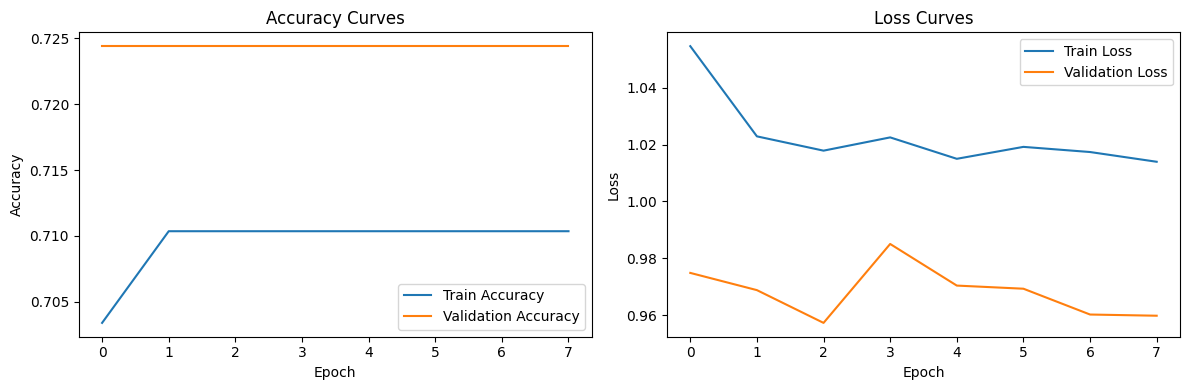

In [ ]:
# Visualization
# ========================

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

plot_training_history(history)